In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math

# All clinical vars Analysis
In this notebook I join the clinical measurements in all_clinical_vars_normal_cohort_LR.csv with the echo report data in preprocessed_normal_cohort_echo_reports.csv to check:
- predictability
- correlation


In [3]:
clin_vars_path = "../all_clinical_vars_normal_cohort_LR.csv"
clin_vars = pd.read_csv(clin_vars_path)
clin_vars["zeitstempel_y"] = pd.to_datetime(clin_vars["zeitstempel_y"])

echo_reports_path = "../patient_info_preprocessed_normal_cohort_echo_reports.csv"
echo_reports = pd.read_csv(echo_reports_path)
echo_reports = echo_reports.drop("Unnamed: 0", axis=1)
echo_reports["echo_report"] = True
echo_reports["echo_report"] = echo_reports["echo_report"].astype('boolean')
echo_reports["echokardiographie_dttm"] = pd.to_datetime(echo_reports["echokardiographie_dttm"])

In [3]:
clin_vars["name"].unique()

array(['HbA1c n.NGSP', 'Kalium', 'Natrium', 'eGFR (Krea) CKD-EPI',
       'Kreatinin', 'NT-proBNP', 'TSH, basal', 'Gewicht', 'Grösse',
       'Lymphozyten', 'Thrombozyten', 'Leukocytes', 'Hemoglobin',
       'Monozyten', 'hsCRP', 'Neutrophile', 'CK', 'Harnsäure',
       'Alk. Phosphatase', 'Ferritin',
       'AST (GOT)Aspartat-Aminotransferase', 'Troponin', 'ICD10',
       'ALT (GPT)Alanin-Aminotransferase', 'Albumin', 'Harnstoff',
       'Bilirubin, total', 'Transferrin Saturation', 'Transferrin',
       'D-Dimers', 'Bicarbonat', 'Laktat'], dtype=object)

In [4]:
clin_vars.shape[0]

148832

Join the clinical variables measured in one visit.

In [8]:
measurements = clin_vars["name"].unique()

clin_vars["value"] = clin_vars["value"].apply(str)
clin_var_visits = clin_vars.groupby(["Pat_ResearchID", "zeitstempel_y"])[["name", "value"]].agg('\\'.join)

new_cols = pd.DataFrame(columns=measurements)
clin_var_visits = pd.concat((clin_var_visits, new_cols), axis=0)

def split_columns(row):
    names = row["name"].split('\\')
    values = row["value"].split('\\')
    for i, name in enumerate(names):
        row[name] = values[i]
    return row

clin_var_visits = clin_var_visits.apply(split_columns, axis=1)
clin_var_visits = clin_var_visits.drop(columns=["name", "value", "ICD10"])
clin_var_visits["clinical_variables"] = True
clin_var_visits["clinical_variables"] = clin_var_visits["clinical_variables"].astype('boolean')
clin_var_visits = clin_var_visits.reset_index()
clin_var_visits.to_csv("../clinical_visits.csv")
clin_var_visits.head()

,Pat_ResearchID,zeitstempel_y,HbA1c n.NGSP,Kalium,Natrium,eGFR (Krea) CKD-EPI,Kreatinin,NT-proBNP,"TSH, basal",Gewicht,...,ALT (GPT)Alanin-Aminotransferase,Albumin,Harnstoff,"Bilirubin, total",Transferrin Saturation,Transferrin,D-Dimers,Bicarbonat,Laktat,clinical_variables
0,ZH-000B3801-6784-4EE5-A79A-2FFFA01875E5,2020-12-18 15:47:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,ZH-000B3801-6784-4EE5-A79A-2FFFA01875E5,2020-12-18 15:50:00,5.2,4.1,138,125,60,80,1.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,ZH-0010FCCD-AEB1-4BA7-9588-D637855A1A87,2019-12-16 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,ZH-0010FCCD-AEB1-4BA7-9588-D637855A1A87,2019-12-16 09:29:00,5.3,NaN,NaN,94,72,38,2.83,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,ZH-005B5041-3470-4BF3-842E-859CA0A3A76E,2013-03-04 07:00:00,NaN,4.1,140,>90,53,NaN,0.92,NaN,...,14,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Join the clinical variable vistits to the echo reports. I do a full outer join so the table will contain:
- Full rows where both echo reports and clinical varibales are present.
- Echo reports rows where no clinical variables where measured.
- Clinical variables rows where no echo report was done.
Note that two full rows might contain the same echo report values because sometimes the clinical variable recording times differ only a little and I join the clinical variables to the echo reports with a timedelta and not exactly.

In [9]:
valid_timedelta = dt.timedelta(hours=1).total_seconds()
print("number of echo reports: ", echo_reports.shape)
print("number of clinical variable visits: ", clin_var_visits.shape)
no_timeconstraints_join = echo_reports.merge(clin_var_visits, how="outer", on="Pat_ResearchID")
no_timeconstraints_join["echo_report"] = no_timeconstraints_join["echo_report"].apply(lambda x: False if x is pd.NA else x)
no_timeconstraints_join["clinical_variables"] = no_timeconstraints_join["clinical_variables"].apply(lambda x: False if x is pd.NA else x)

print("number of full rows, echo report only and clin var only: ", no_timeconstraints_join.shape)
no_timeconstraints_join["timedelta"] = no_timeconstraints_join["echokardiographie_dttm"] - no_timeconstraints_join["zeitstempel_y"]
no_timeconstraints_join["timedelta"] = no_timeconstraints_join["timedelta"].apply(lambda delta: abs(delta.total_seconds()))

print("number of echo report only rows: ", no_timeconstraints_join[no_timeconstraints_join["echo_report"] & ~no_timeconstraints_join["clinical_variables"]].shape)
print("number of clin var only: ", no_timeconstraints_join[no_timeconstraints_join["clinical_variables"] & ~no_timeconstraints_join["echo_report"]].shape)
print("number of full rows:", no_timeconstraints_join[no_timeconstraints_join["clinical_variables"] & no_timeconstraints_join["echo_report"]].shape)

def timedelta_filter(row):
    full_row = row["echo_report"] and row["clinical_variables"]
    if full_row:
        return row["timedelta"] > valid_timedelta
    return False
  
no_timeconstraints_join["split"] = no_timeconstraints_join.apply(timedelta_filter, axis=1)

# Split joined rows with too large timedelta into one row for the echo report and one row for the clinical variables
def split(row):
    if row["split"]:
        for key, val in row.items():
            if key != "Pat_ResearchID":
                if key in echo_reports.columns:
                    row[key] = [np.NAN, val]
                else:
                    row[key] = [val, np.NAN]
    return row

join = no_timeconstraints_join.apply(split, axis=1)

explode_columns = list(join.columns)
explode_columns.remove("Pat_ResearchID")
join = join.explode(column=explode_columns)
print("number of rows after splitting full rows with too large a timedelta", join.shape)
join = join.drop(columns=["Fall_ResearchID", "Datum_Echokardiographie", "Uhrzeit_Echokardiographie", "echokardiographie_dttm", "zeitstempel_y", "timedelta", "split"])
join = join.drop_duplicates()
print("number of rows after removing duplicates: ", join.shape)
join.head()


number of echo reports:  (4138, 35)
number of clinical variable visits:  (21547, 34)
number of full rows, echo report only and clin var only:  (22193, 68)
number of echo report only rows:  (3, 69)
number of clin var only:  (1595, 69)
number of full rows: (20595, 69)
number of rows after splitting full rows with too large a timedelta (40759, 70)
number of rows after removing duplicates:  (23992, 63)


,Pat_ResearchID,Groesse_Echokardiographie,Gewicht_Echokardiographie,BMI,Echoqualitaet,Mitralklappe,Aortenklappe,Aorta,Trikuspidalklappe,Pulmonalklappe,...,ALT (GPT)Alanin-Aminotransferase,Albumin,Harnstoff,"Bilirubin, total",Transferrin Saturation,Transferrin,D-Dimers,Bicarbonat,Laktat,clinical_variables
0,ZH-85A27098-5BC2-47A5-8B83-3FFFB8EA6FBF,157.0,83.0,33.7,gut,normal,normal,nicht normal,normal,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,ZH-85A27098-5BC2-47A5-8B83-3FFFB8EA6FBF,157.0,83.0,33.7,gut,normal,normal,nicht normal,normal,normal,...,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,ZH-C8BF6C68-A802-4AB0-BEDA-176784BDDEC3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,ZH-C8BF6C68-A802-4AB0-BEDA-176784BDDEC3,178.0,93.0,29.4,gut,normal,normal,normal,normal,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZH-C8BF6C68-A802-4AB0-BEDA-176784BDDEC3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN,True


First clean the columns by removing non-numeric (ex: k.Mat., Nicht durchgeführt - Verordnung wurde durch Auftraggeber gelöscht, Verwechslung (falscher Patient gestochen), ...) and non-exact (>0.005, ...) values. Then map the df columns to the correct dtype.

In [10]:
numeric_columns = ['Groesse_Echokardiographie', 'Gewicht_Echokardiographie', 'BMI',
                   'ESD_M_Mode', 'ESV', 'EDV', 'EF','Septum', 'Hinterwand', 'EDD', 'LVMMI',
                    'rTh', 'LV_Fuellung', 'HeartFrequency', 'BloodPressure_Systole',
                    'BloodPressure_Diastole', 'HbA1c n.NGSP', 'Kalium', 'Natrium',
                    'eGFR (Krea) CKD-EPI', 'Kreatinin', 'NT-proBNP', 'TSH, basal',
                    'Gewicht', 'Grösse', 'Lymphozyten', 'Thrombozyten', 'Leukocytes',
                    'Hemoglobin', 'Monozyten', 'hsCRP', 'Neutrophile', 'CK', 'Harnsäure',
                    'Alk. Phosphatase', 'Ferritin', 'AST (GOT)Aspartat-Aminotransferase',
                    'Troponin', 'ALT (GPT)Alanin-Aminotransferase', 'Albumin', 'Harnstoff',
                    'Bilirubin, total', 'Transferrin Saturation', 'Transferrin', 'D-Dimers',
                    'Bicarbonat', 'Laktat']

def convert(val):
    if isinstance(val, str):
        try:
            return float(val)
        except ValueError:
            return np.NaN
    elif not np.isnan(val):
        return float(val)
    return np.NaN

for column in join.columns:
    if column in numeric_columns:
        join[column] = join[column].apply(convert)
    try:
        join[column] = join[column].astype("float")
        print(column, " - Float")
    except (ValueError, TypeError) as e:
        print(column, " - not Float")

join.to_csv("../normal_cohort_echo_reports_and_clinical_variables.csv")
join.info()


Pat_ResearchID  - not Float
Groesse_Echokardiographie  - Float
Gewicht_Echokardiographie  - Float
BMI  - Float
Echoqualitaet  - not Float
Mitralklappe  - not Float
Aortenklappe  - not Float
Aorta  - not Float
Trikuspidalklappe  - not Float
Pulmonalklappe  - not Float
VenaCavaInferior  - not Float
RechterVorhof  - not Float
RechterVentrikel  - not Float
LinkerVorhof  - not Float
ESD_M_Mode  - Float
LinkerVentrikel  - not Float
ESV  - Float
EDV  - Float
EF  - Float
Ebene  - not Float
RegionaleWandbewegungen  - not Float
Septum  - Float
Hinterwand  - Float
EDD  - Float
LVMMI  - Float
rTh  - Float
LV_Fuellung  - Float
HeartFrequency  - Float
BloodPressure_Systole  - Float
BloodPressure_Diastole  - Float
echo_report  - Float
HbA1c n.NGSP  - Float
Kalium  - Float
Natrium  - Float
eGFR (Krea) CKD-EPI  - Float
Kreatinin  - Float
NT-proBNP  - Float
TSH, basal  - Float
Gewicht  - Float
Grösse  - Float
Lymphozyten  - Float
Thrombozyten  - Float
Leukocytes  - Float
Hemoglobin  - Float
Monozyten  -

array([[<AxesSubplot:title={'center':'HbA1c n.NGSP'}>,
        <AxesSubplot:title={'center':'Kalium'}>,
        <AxesSubplot:title={'center':'Natrium'}>,
        <AxesSubplot:title={'center':'eGFR (Krea) CKD-EPI'}>,
        <AxesSubplot:title={'center':'Kreatinin'}>,
        <AxesSubplot:title={'center':'NT-proBNP'}>],
       [<AxesSubplot:title={'center':'TSH, basal'}>,
        <AxesSubplot:title={'center':'Gewicht'}>,
        <AxesSubplot:title={'center':'Grösse'}>,
        <AxesSubplot:title={'center':'Lymphozyten'}>,
        <AxesSubplot:title={'center':'Thrombozyten'}>,
        <AxesSubplot:title={'center':'Leukocytes'}>],
       [<AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Monozyten'}>,
        <AxesSubplot:title={'center':'hsCRP'}>,
        <AxesSubplot:title={'center':'Neutrophile'}>,
        <AxesSubplot:title={'center':'CK'}>,
        <AxesSubplot:title={'center':'Harnsäure'}>],
       [<AxesSubplot:title={'center':'Alk. Phosphatase'}>,


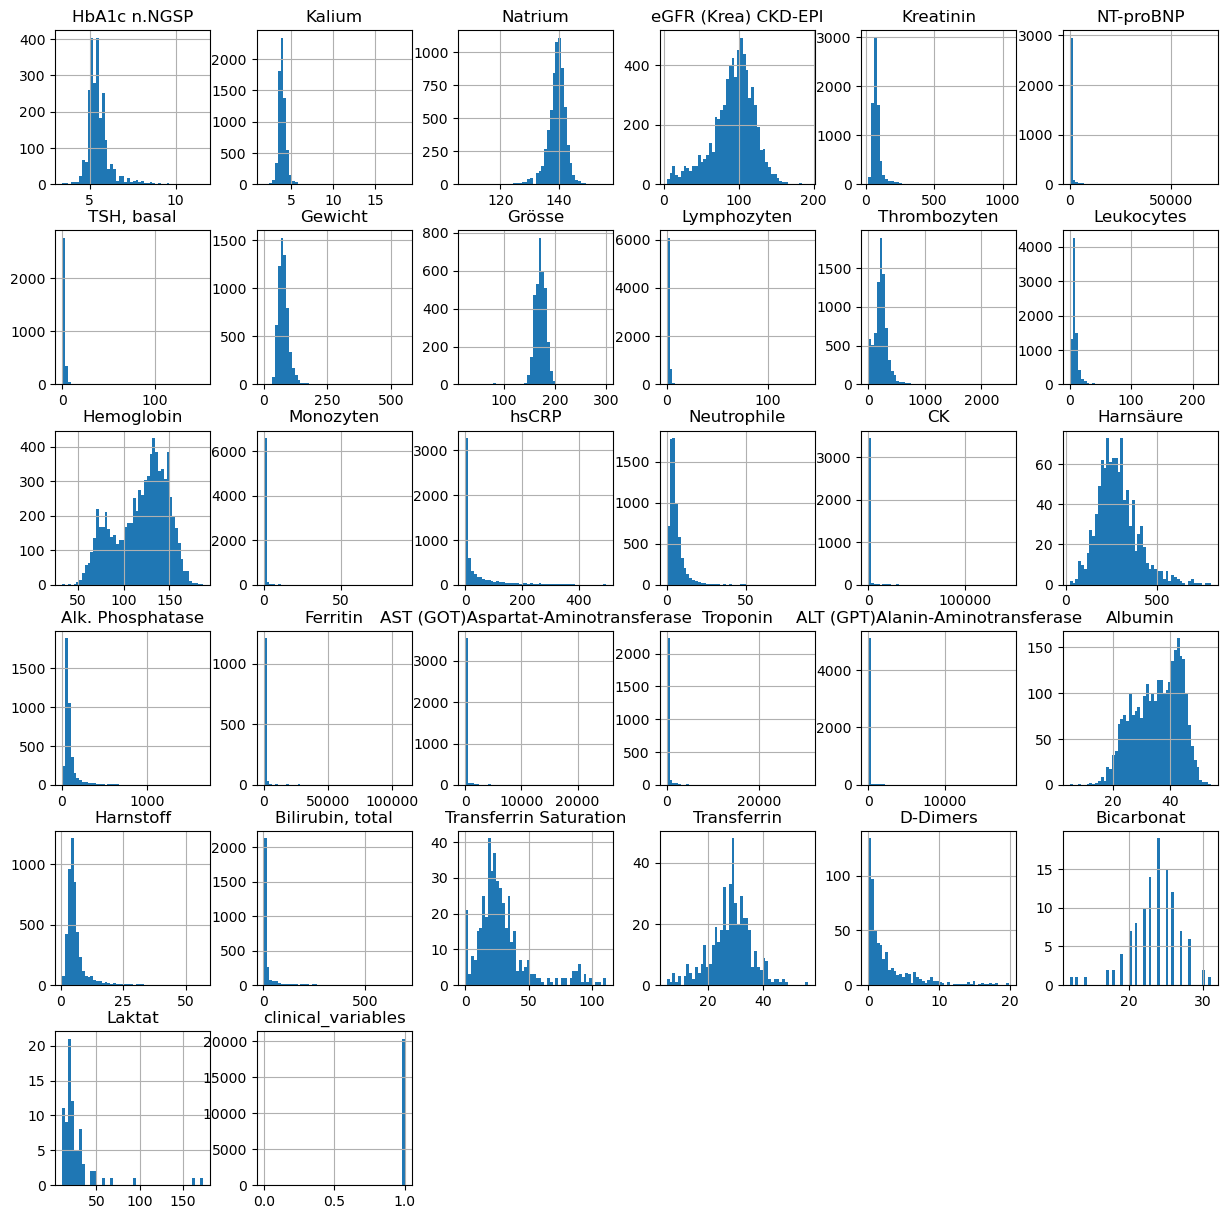

In [8]:
join[clin_var_visits.drop(columns="zeitstempel_y").columns].hist(bins=50, figsize=(15,15))

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/usr/local/anaconda3/lib/python3

<AxesSubplot:>

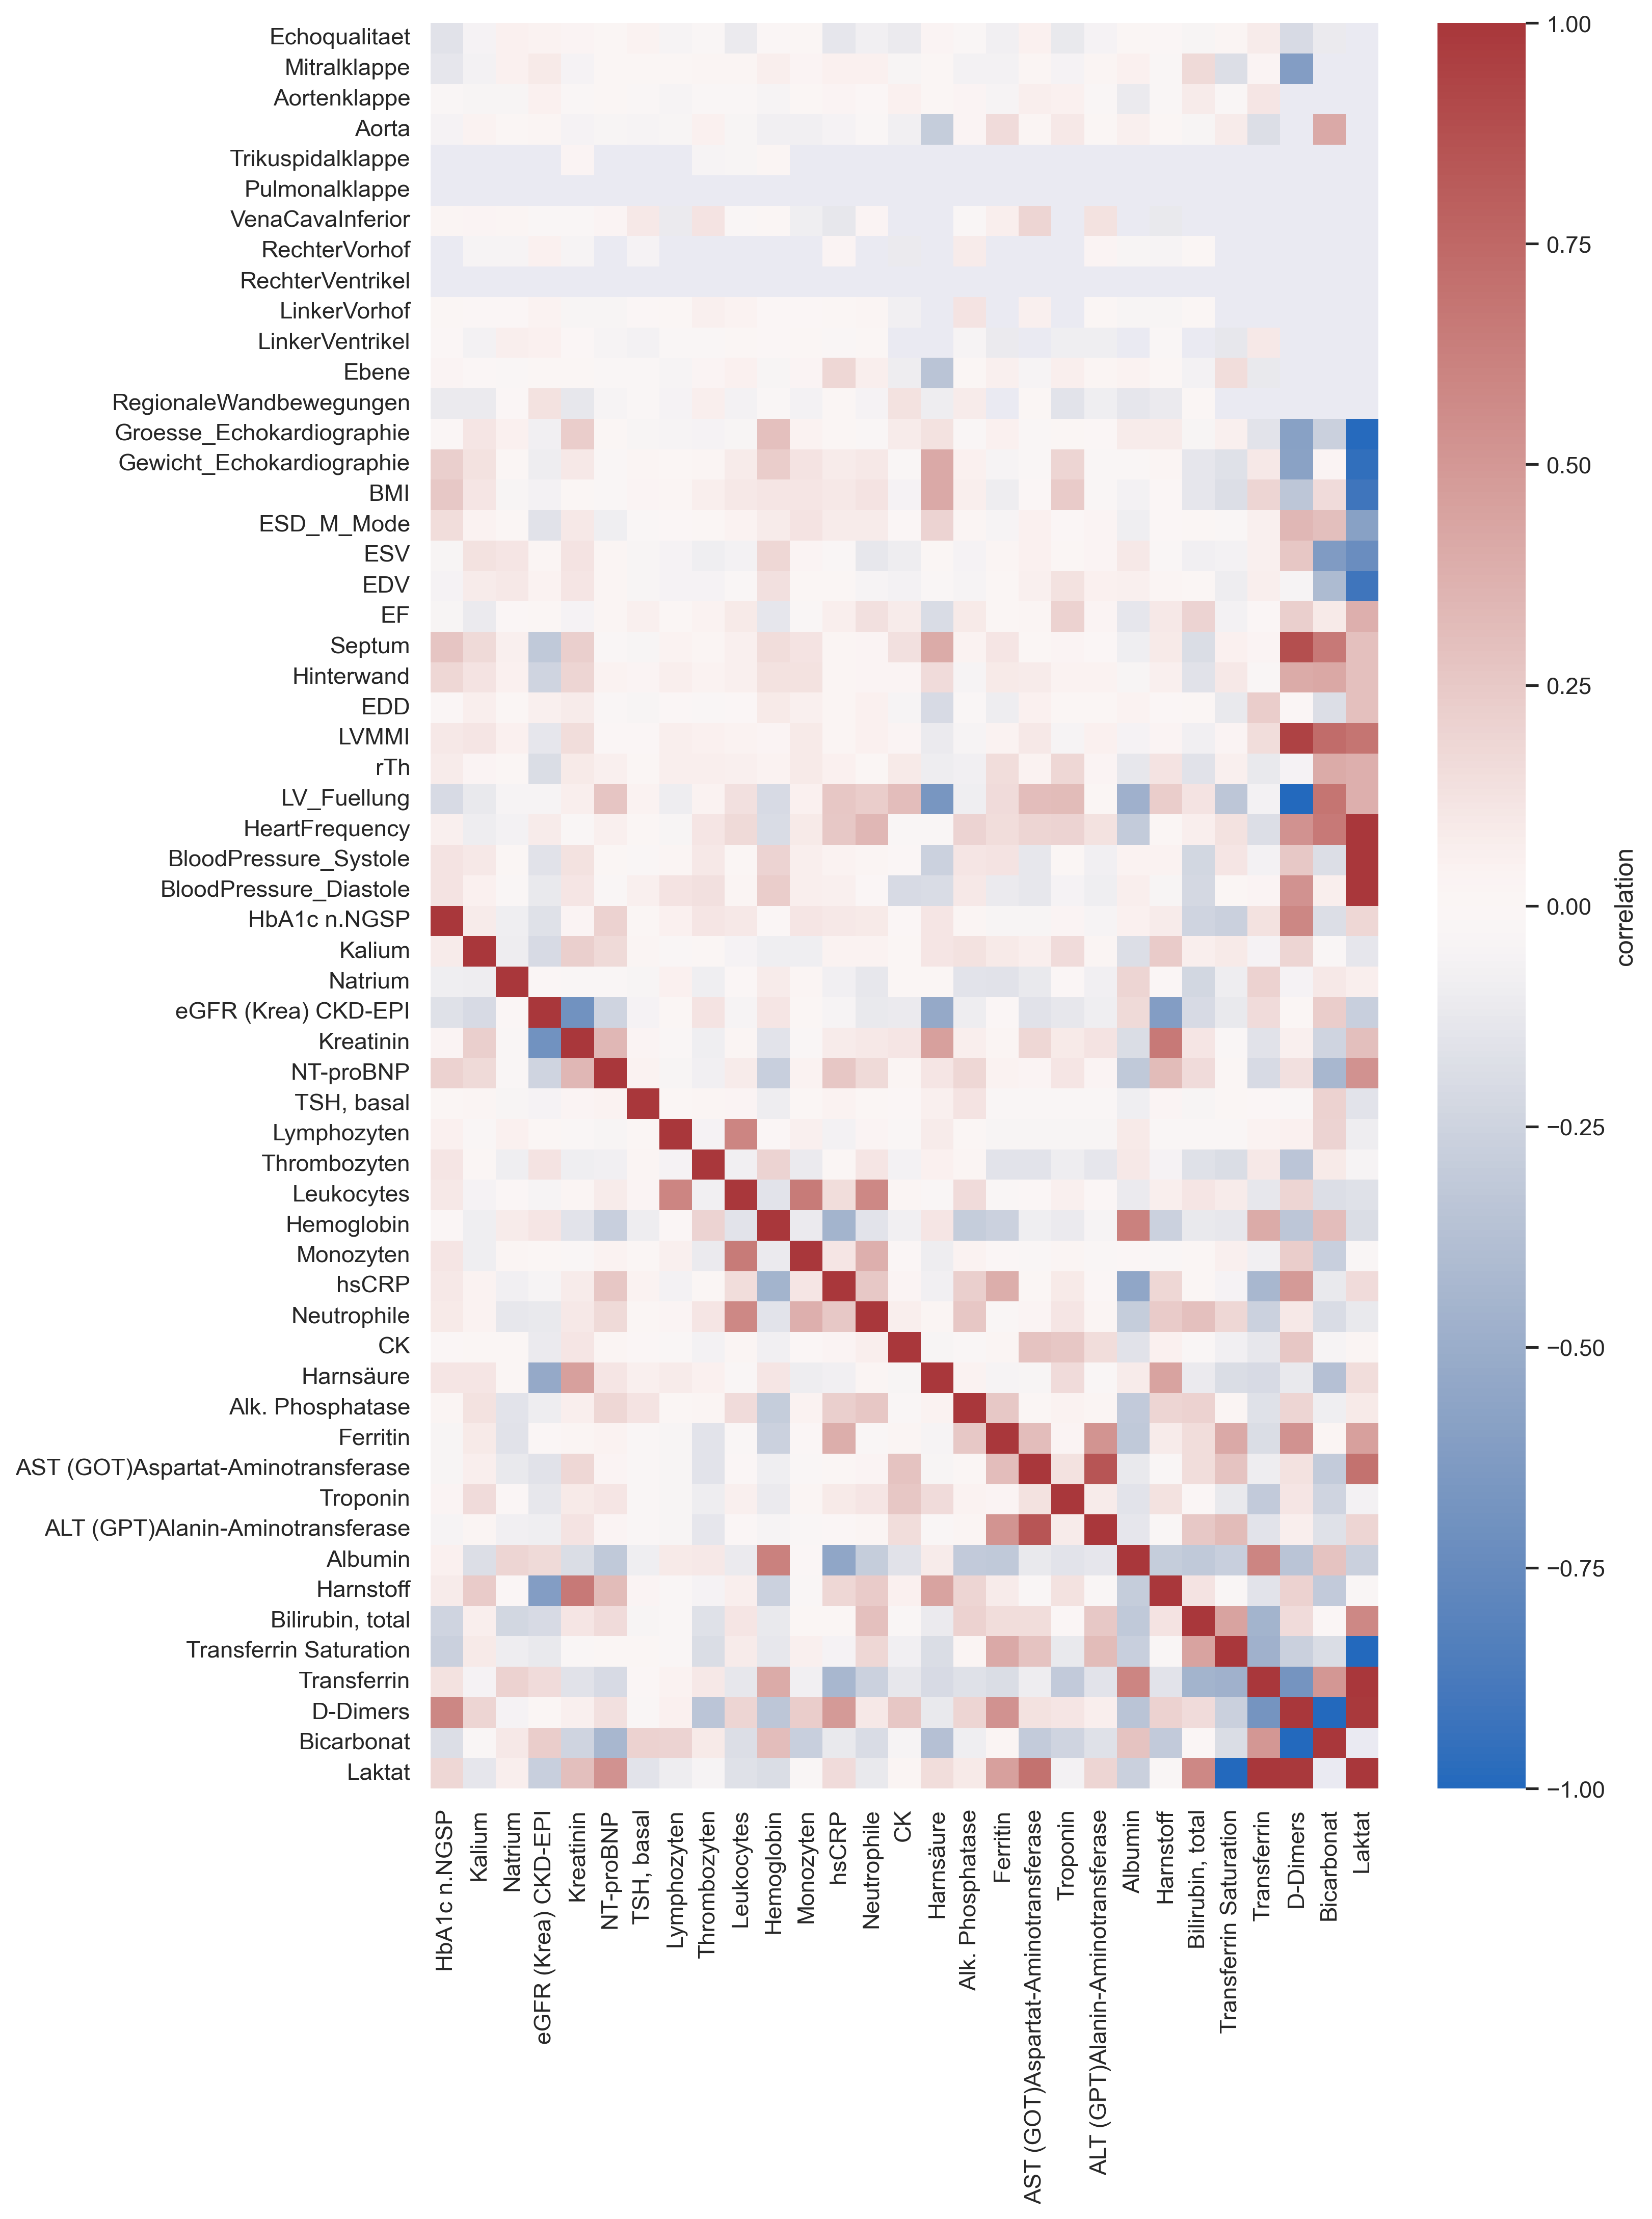

In [28]:
normal_map = lambda s: 0 if s == "nicht normal" else 1
extended_normal_map = lambda s: 0 if s == "Ersetzt" else 1 if s == "nicht normal" else 2
gut_map = lambda s: 0 if s == "genügend" else 1
echo_variables = echo_reports.columns.drop(labels=["Pat_ResearchID", "Fall_ResearchID", "echokardiographie_dttm", "Datum_Echokardiographie", "Uhrzeit_Echokardiographie", "echo_report"])

def normalize_df(df, method="mean"):
    num_df = df.select_dtypes('number')
    
    if method == "min-max":
        normalized_num_df=(num_df-num_df.min())/(num_df.max()-num_df.min())
    elif method == "mean":
        normalized_num_df=(num_df-num_df.min())/(num_df.max()-num_df.min())
    else:
        print(method, " is no valid normalization method")
    return pd.concat((df.select_dtypes('object'), normalized_num_df), axis=1)



def filter_df(df, filter_var, filter_val, mapped_strings=True):
    
    filter_indices = df[filter_var].between(filter_val[0], filter_val[1])
    
    return df[filter_indices]



def correlation(df, only_numerical,  normalize="mean", filter_var=None, filter_val=None):

    if normalize != "":
        df = normalize_df(df, method="mean")

    if only_numerical:
        df = df.select_dtypes('number')
    
    if not filter_var is None:
        df = filter_df(df, filter_var, filter_val)
    
    correlation_table = case_correlation(df).round(2)

    return correlation_table


def case_correlation(df):
    columns = df.columns

    # create quadratic matrix with columns as index and columns as columns
    correlation_table = pd.DataFrame(index=columns, columns=columns)

    min_rows = df.shape[0]

    for var_a in columns:
        for var_b in columns:
            n_rows = df[[var_a, var_b]].dropna().shape[0]
            min_rows = min(min_rows, n_rows)
            if df[var_a].dtype == 'object' or df[var_b].dtype == 'object':
                correlation_table[var_a][var_b] = df[var_a].corr(df[var_b], method='spearman')
            else:
                correlation_table[var_a][var_b] = df[var_a].corr(df[var_b], method='pearson')
        
    return correlation_table.astype("float")


def drop_echo_correlations(corr_table, echo_variables):
    corr_table = corr_table.drop(columns=echo_variables)
    return corr_table

corr = correlation(join.drop(columns=["Pat_ResearchID", "clinical_variables", "Gewicht",  "Grösse", "echo_report"]), normalize="mean", only_numerical=False)
corr = drop_echo_correlations(corr, echo_variables)

corr.to_csv("clinical_variables_correlation.csv")

fig, ax = plt.subplots(figsize=(10,15))  
sns.set(rc={"figure.dpi":300, 'savefig.dpi':500})
sns.heatmap(corr, square=False, cbar_kws={'label': 'correlation'}, vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True), ax=ax)


Print all varaiables with correlation higher than a certain threshold

In [29]:
threshold = 0.25

columns = list(corr.columns)
indices = list(corr.index)
above_corr_pairs = []

for i, col in enumerate(columns):
    for j, idx in enumerate(indices):
        if i - j >= -28:
            curr_corr = corr[col][idx]
            print(col, idx, curr_corr)
            if abs(curr_corr) > threshold:
                print("{} - {} : {}".format(col, idx, curr_corr))
                above_corr_pairs.append((col, idx, curr_corr))

HbA1c n.NGSP Echoqualitaet -0.16
HbA1c n.NGSP Mitralklappe -0.14
HbA1c n.NGSP Aortenklappe -0.03
HbA1c n.NGSP Aorta -0.06
HbA1c n.NGSP Trikuspidalklappe nan
HbA1c n.NGSP Pulmonalklappe nan
HbA1c n.NGSP VenaCavaInferior 0.02
HbA1c n.NGSP RechterVorhof nan
HbA1c n.NGSP RechterVentrikel nan
HbA1c n.NGSP LinkerVorhof -0.0
HbA1c n.NGSP LinkerVentrikel -0.01
HbA1c n.NGSP Ebene 0.03
HbA1c n.NGSP RegionaleWandbewegungen -0.11
HbA1c n.NGSP Groesse_Echokardiographie -0.01
HbA1c n.NGSP Gewicht_Echokardiographie 0.22
HbA1c n.NGSP BMI 0.25
HbA1c n.NGSP ESD_M_Mode 0.15
HbA1c n.NGSP ESV -0.04
HbA1c n.NGSP EDV -0.06
HbA1c n.NGSP EF -0.04
HbA1c n.NGSP Septum 0.27
HbA1c n.NGSP - Septum : 0.27
HbA1c n.NGSP Hinterwand 0.18
HbA1c n.NGSP EDD -0.01
HbA1c n.NGSP LVMMI 0.1
HbA1c n.NGSP rTh 0.08
HbA1c n.NGSP LV_Fuellung -0.21
HbA1c n.NGSP HeartFrequency 0.06
HbA1c n.NGSP BloodPressure_Systole 0.12
HbA1c n.NGSP BloodPressure_Diastole 0.12
Kalium Echoqualitaet -0.06
Kalium Mitralklappe -0.07
Kalium Aortenklappe -

Plot the value corresponding value distributions for pairs with correlation above the thresshold.

HbA1c n.NGSP - Septum : 0.27 - based on 566 patients.
eGFR (Krea) CKD-EPI - Septum : -0.32 - based on 683 patients.
NT-proBNP - LV_Fuellung : 0.27 - based on 217 patients.
Hemoglobin - Groesse_Echokardiographie : 0.29 - based on 700 patients.
hsCRP - LV_Fuellung : 0.26 - based on 114 patients.
Neutrophile - HeartFrequency : 0.34 - based on 603 patients.
CK - LV_Fuellung : 0.31 - based on 57 patients.
AST (GOT)Aspartat-Aminotransferase - LV_Fuellung : 0.31 - based on 77 patients.
Albumin - HeartFrequency : -0.3 - based on 160 patients.


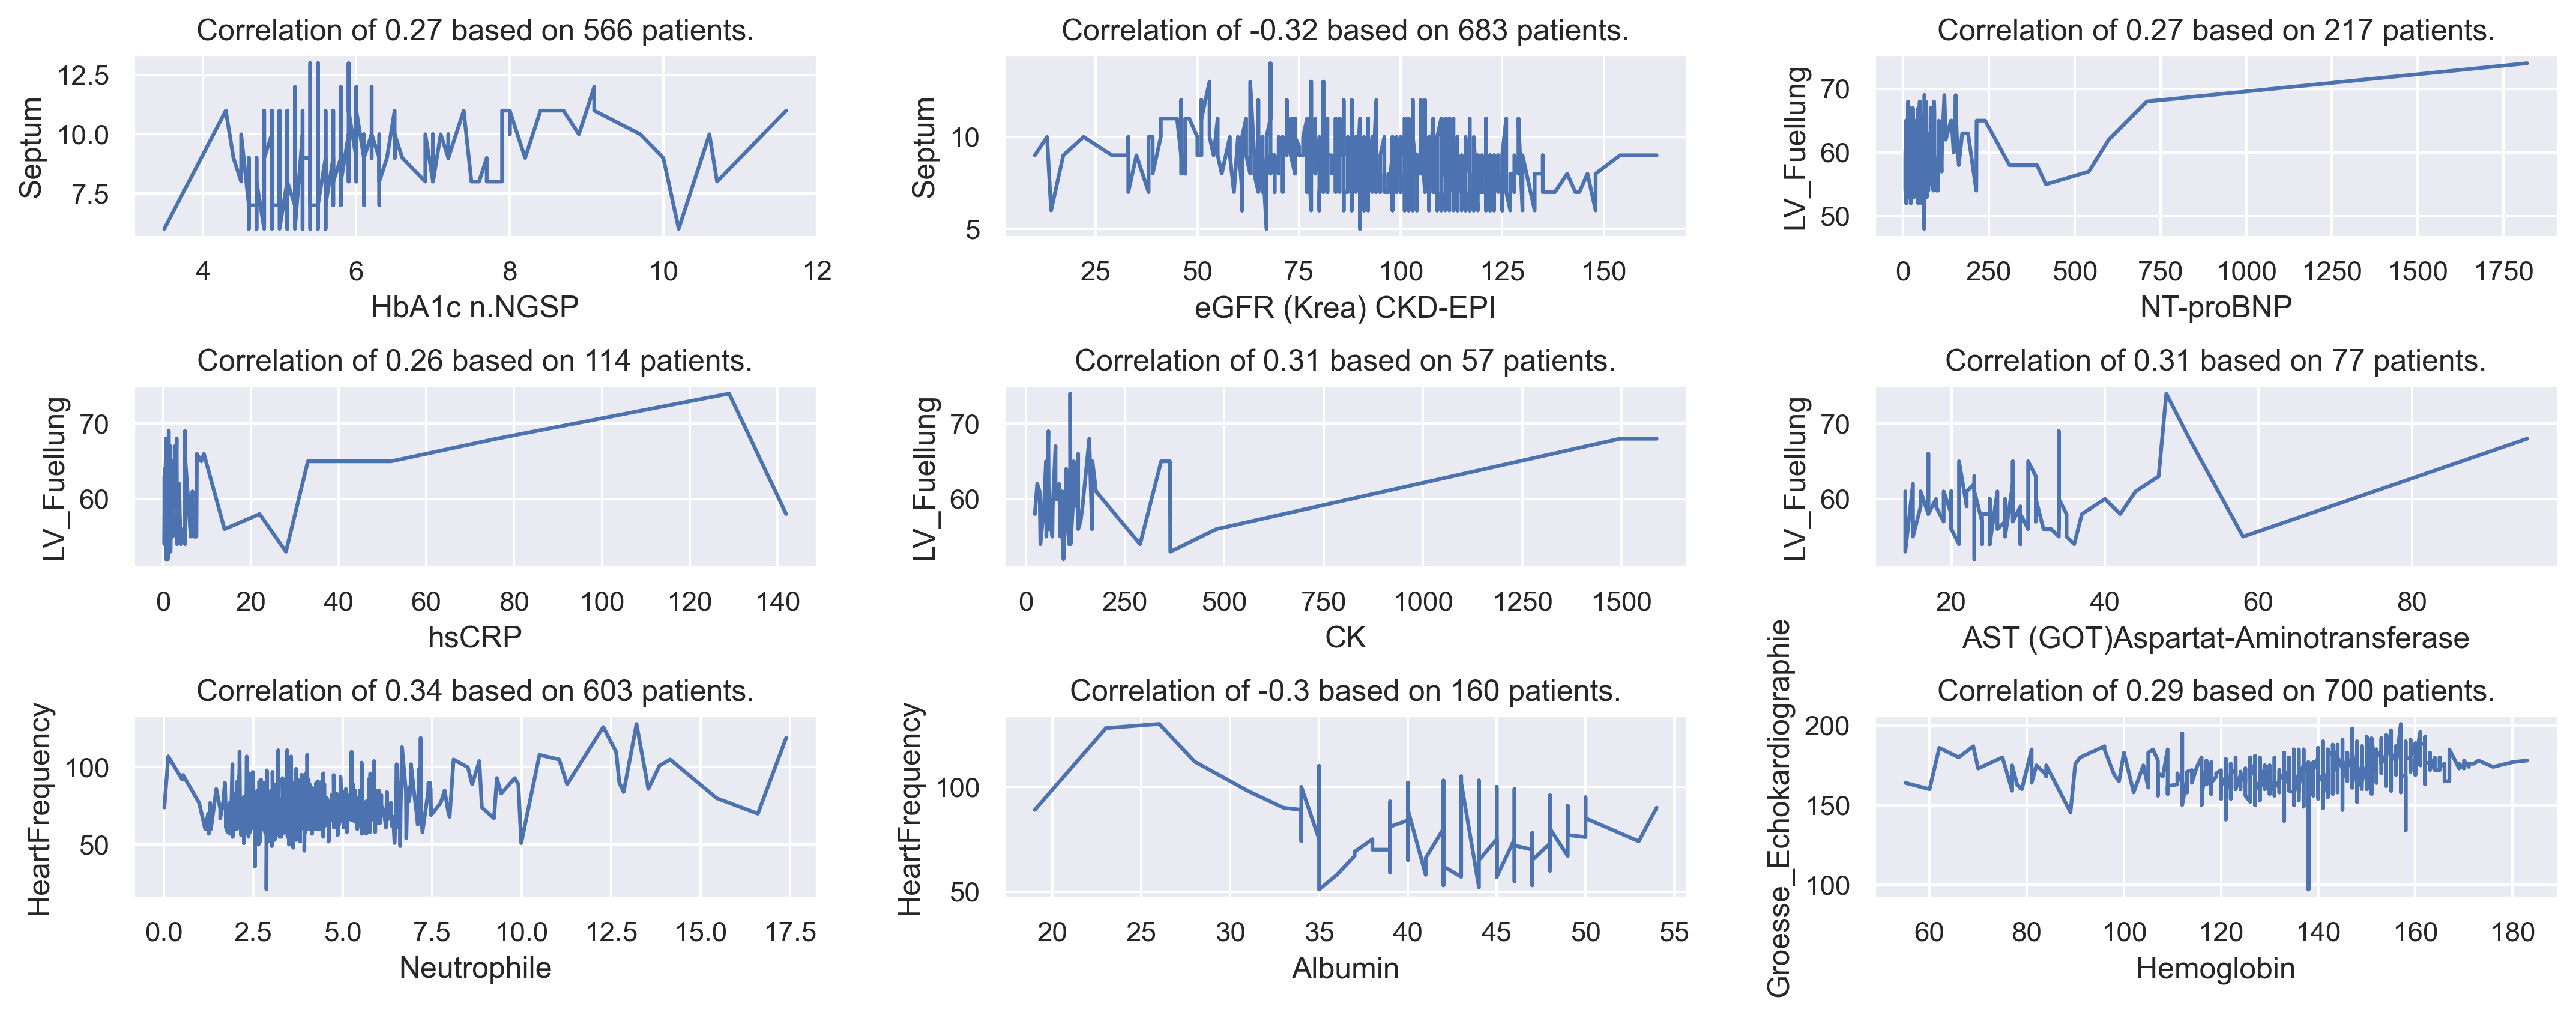

In [31]:
interesting_pairs = []

for var_a, var_b, pair_correlation in above_corr_pairs:
    pair_df = join[join[var_a].notna() & join[var_b].notna()][[var_a, var_b]]
    pair_df = pair_df.sort_values(var_a)
    if (var_a in echo_variables or var_b in echo_variables) and pair_df.shape[0] > 50:
        print("{} - {} : {} - based on {} patients.".format(var_a, var_b, pair_correlation, pair_df.shape[0]))
        if pair_df[var_a].dtype != "object" and pair_df[var_b].dtype != "object":
            #pair_df.plot(x=var_a, y=var_b)
            #plt.title("Correlation of {} based on {} patients.".format(pair_correlation, pair_df.shape[0]))
            interesting_pairs.append((pair_df[var_a], pair_df[var_b], var_a, var_b, pair_correlation, pair_df.shape[0], pair_correlation))

interesting_pairs = sorted(interesting_pairs, key=lambda x: x[3], reverse=True)

fig, ax = plt.subplots(ncols=3, nrows=math.ceil(len(interesting_pairs)/3), figsize=(15,2*math.ceil(len(interesting_pairs)/3)), dpi=300)
fig.tight_layout(pad=3.0)
for row in ax:
    for col in row:
        if len(interesting_pairs) > 0:
            col.plot(interesting_pairs[0][0], interesting_pairs[0][1])
            col.title.set_text("Correlation of {} based on {} patients.".format(interesting_pairs[0][4], interesting_pairs[0][5]))
            col.set_xlabel(interesting_pairs[0][2])
            col.set_ylabel(interesting_pairs[0][3])
            interesting_pairs.pop(0)